# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np
import os

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
from tqdm.auto import tqdm
import seaborn as sns
import torchsummary
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

sns.set(palette='summer')
sns.set(style="whitegrid", font_scale=1.2)

In [3]:
import PIL
print(PIL.__version__)

9.4.0


In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
!unzip -q /content/gdrive/MyDrive/Deep_Learning_MIPT_1/part_14/journey-springfield.zip

# Для трейна сделал свой датасет с фиксированной аугментацией, который включает:
## - Оригинальную картинку
## - Оригинальную картинку отраженную вдоль оси Y
## - Оригинальную картинку повернутую на рандомный угол от 10 до 30 градусов влево и вправо
## - отраженную вдоль оси Y повернутую на рандомный угол от 10 до 30 градусов влево и вправо

## То есть всего 1 картинка -> 6 картинок
 
## До этого я пробовал использовать аугментацию как на семинаре (то есть добавлять аугментацию внутрь самописного класса SimpsonsDataset), но она показала себя чуть хуже на тесте.

In [8]:
!unzip -q /content/gdrive/MyDrive/Deep_Learning_MIPT_1/part_14/augmented_train_2.zip

In [9]:
!ls train

simpsons_dataset


In [10]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Apr 12 20:53:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              23W / 300W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [11]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [12]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [13]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [14]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [15]:
#определим директории с тренировочными и тестовыми файлами
# TRAIN_DIR = Path('./train/')
TRAIN_DIR = Path('./augmented_train_2/')
TEST_DIR = Path('./testset')

In [16]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [17]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [18]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [19]:
train_dataset = SimpsonsDataset(train_files, mode='train')

Давайте посмотрим на наших героев внутри датасета.

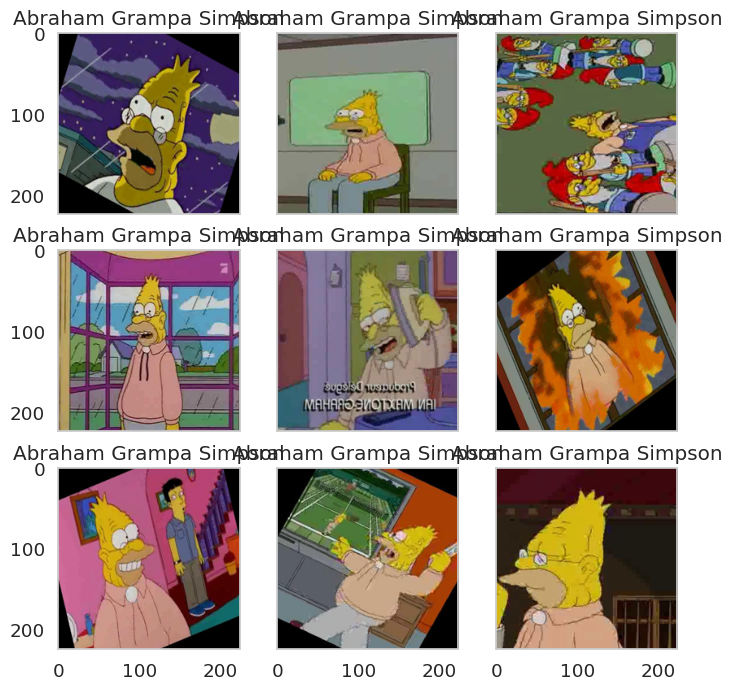

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


## Я пробовал различные модфикации собственной полностью обученной с нуля CNN лучшей оказалась модификация ниже (дала ф1-скор на тесте = 0.92)
## Также в рамках этого исследования я пробовал разные значения размеров батча, регуляризации, лернинг рейта (как видно они добавлены в трейн функцию как аргументы).

## Однако для лучшего результата я решил дообучать ResNet18

In [22]:
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv1x1_1 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=1),
            nn.BatchNorm2d(96),
            nn.ReLU()
        )

        self.conv1x1_2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=48, kernel_size=1),
            nn.BatchNorm2d(48),
            nn.ReLU()
        )

        self.fc1 = nn.Sequential(
            nn.Linear(48 * 5 * 5, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Dropout(p=0.3)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Dropout(p=0.3)
        )

        self.out = nn.Linear(100, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv1x1_1(x)
        x = self.conv1x1_2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        logits = self.out(x)
        return logits

In [23]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [24]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [25]:
def train(train_files, val_files, model, epochs, batch_size, model_dir, learning_rate=1e-3, L2_reg=1e-5, acc_tol=0.02):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=L2_reg)
        criterion = nn.CrossEntropyLoss()

        max_val_acc = 0
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            torch.save(model.state_dict(), os.path.join(model_dir, 'epoch-{}.pt'.format(epoch)))
            if val_acc > max_val_acc:
                max_val_acc = val_acc
            elif val_acc < max_val_acc - acc_tol:
                best_epoch  = epoch - 1
                print(f'best_epoch =', best_epoch)

    return history

In [26]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

# Дообучим ResNet18 для которого добавим еще один полносвязный слой длинны 512 с батчнормом и дропаутом и заменим количество выходов на последнем слое на количество классов.

# Разморозим 20 верхних feature extracor`ов ResNet18

In [28]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

In [29]:
resnet_fc_in = model.fc.in_features
n_classes = len(np.unique(train_val_labels))

model.fc = nn.Sequential(
    nn.Linear(resnet_fc_in, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(p=0.3),
    nn.Linear(512, n_classes)
)

In [30]:
N_layers = len(list(model.parameters()))
N_unfreezed_layers = 20 + 2

for idx, param in enumerate(model.parameters()):
    if idx < (N_layers - N_unfreezed_layers):
        param.requires_grad = False
    else:
        param.requires_grad = True
        print(f'{idx} {len(param)} is unfreezed')

44 256 is unfreezed
45 512 is unfreezed
46 512 is unfreezed
47 512 is unfreezed
48 512 is unfreezed
49 512 is unfreezed
50 512 is unfreezed
51 512 is unfreezed
52 512 is unfreezed
53 512 is unfreezed
54 512 is unfreezed
55 512 is unfreezed
56 512 is unfreezed
57 512 is unfreezed
58 512 is unfreezed
59 512 is unfreezed
60 512 is unfreezed
61 512 is unfreezed
62 512 is unfreezed
63 512 is unfreezed
64 42 is unfreezed
65 42 is unfreezed


In [31]:
torchsummary.summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Запустим обучение сети.

In [32]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

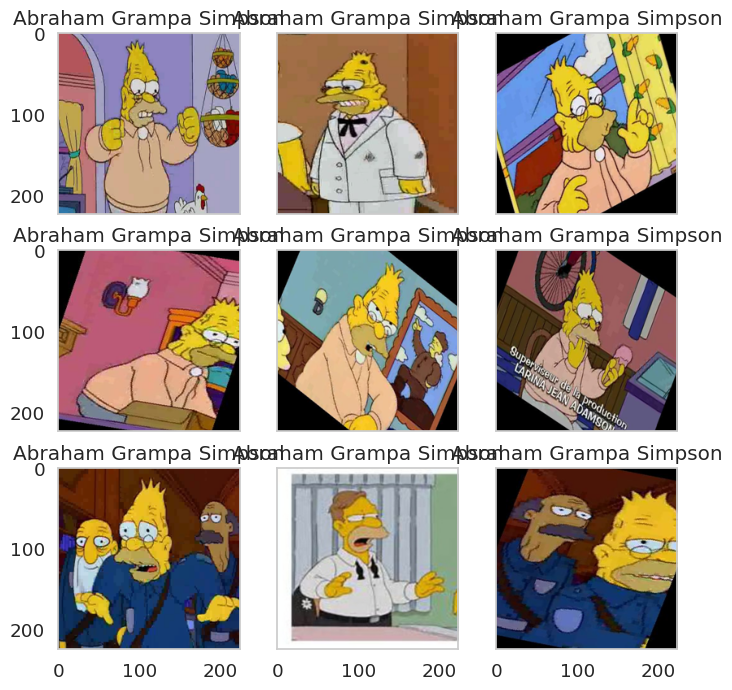

In [33]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_train.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [34]:
%%time

history = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=64, learning_rate=1e-3, L2_reg=1e-3,
                model_dir='/content/gdrive/MyDrive/Deep_Learning_MIPT_1/part_14/resnet_unfreezed_aug_my/', acc_tol=0.01)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.4091967777233675


epoch:  10%|█         | 1/10 [13:49<2:04:29, 829.91s/it]


Epoch 001 train_loss: 0.4092     val_loss 0.3001 train_acc 0.8944 val_acc 0.9225
loss 0.8797876198547818


epoch:  20%|██        | 2/10 [26:57<1:47:19, 804.95s/it]


Epoch 002 train_loss: 0.8798     val_loss 0.3080 train_acc 0.7686 val_acc 0.9174
loss 0.2478052107373449


epoch:  30%|███       | 3/10 [39:53<1:32:22, 791.72s/it]


Epoch 003 train_loss: 0.2478     val_loss 0.2243 train_acc 0.9330 val_acc 0.9415
loss 0.19638589172830864


epoch:  40%|████      | 4/10 [52:42<1:18:17, 782.92s/it]


Epoch 004 train_loss: 0.1964     val_loss 0.2250 train_acc 0.9468 val_acc 0.9400
loss 0.17485198444243324


epoch:  50%|█████     | 5/10 [1:05:06<1:04:03, 768.70s/it]


Epoch 005 train_loss: 0.1749     val_loss 0.2586 train_acc 0.9520 val_acc 0.9277
best_epoch = 3
loss 0.15814425160015244


epoch:  60%|██████    | 6/10 [1:17:37<50:51, 762.77s/it]


Epoch 006 train_loss: 0.1581     val_loss 0.2018 train_acc 0.9564 val_acc 0.9438
loss 0.14503060897584097


epoch:  70%|███████   | 7/10 [1:30:18<38:06, 762.07s/it]


Epoch 007 train_loss: 0.1450     val_loss 0.2001 train_acc 0.9600 val_acc 0.9456
loss 0.13937515901139558


epoch:  80%|████████  | 8/10 [1:42:52<25:19, 759.65s/it]


Epoch 008 train_loss: 0.1394     val_loss 0.2079 train_acc 0.9608 val_acc 0.9427
loss 0.13108356439782423


epoch:  90%|█████████ | 9/10 [1:55:47<12:44, 764.48s/it]


Epoch 009 train_loss: 0.1311     val_loss 0.2073 train_acc 0.9632 val_acc 0.9445
loss 0.1242657656960901


epoch: 100%|██████████| 10/10 [2:08:35<00:00, 771.53s/it]


Epoch 010 train_loss: 0.1243     val_loss 0.2071 train_acc 0.9653 val_acc 0.9439
CPU times: user 2h 34s, sys: 6min 35s, total: 2h 7min 9s
Wall time: 2h 8min 35s


Построим кривые обучения

In [35]:
loss, acc, val_loss, val_acc = zip(*history)

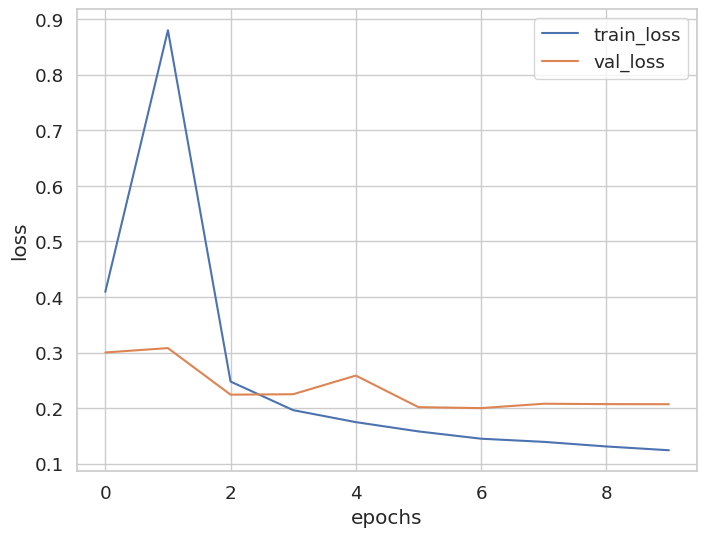

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [37]:
val_acc_corr = []
for i in range(0,len(val_acc)):
  val_acc_corr.append(val_acc[i].item())

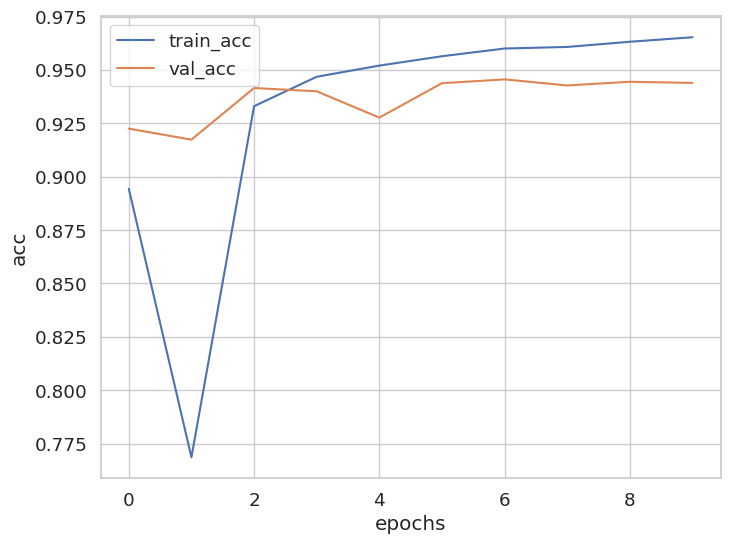

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(acc, label="train_acc")
plt.plot(val_acc_corr, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [39]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [40]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [41]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [42]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [43]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [44]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.85


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

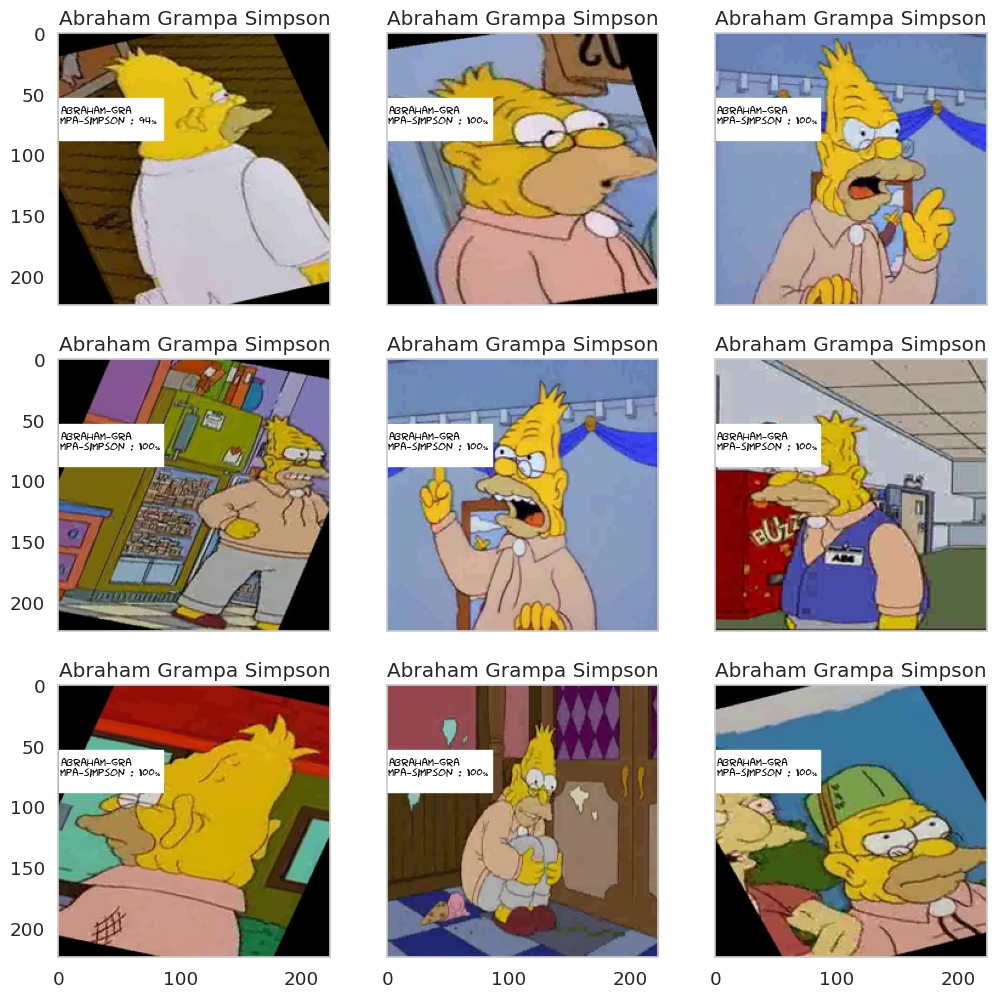

In [45]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [46]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [47]:
! ls

augmented_train_2	     gdrive		sample_data	       testset
characters_illustration.png  label_encoder.pkl	sample_submission.csv  train


In [49]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

# Загружаем лучшую эпоху (в данном случае - 7)

In [52]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Deep_Learning_MIPT_1/part_14/resnet_unfreezed_aug_my/epoch-7.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [53]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [54]:
import pandas as pd
# my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [55]:
submit_name = '/content/gdrive/MyDrive/Deep_Learning_MIPT_1/part_14/predictions/resnet_20_layers_unfreezed_fcBN_dropout03_aug_my_best_epoch.csv'
my_submit.to_csv(submit_name, index=False)

In [56]:
from google.colab import files
files.download(submit_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Получили ф1-скор на тесте = 0.966

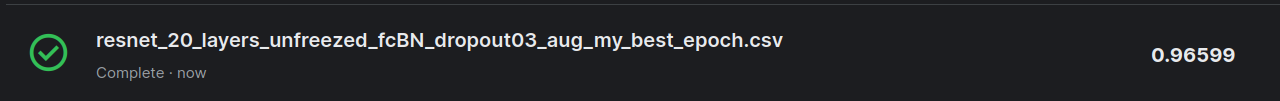